In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from netCDF4 import Dataset
from glob import glob
from os.path import join
from marbleri.models import ResNet, StandardConvNet
from marbleri.nwp import HWRFSequence, BestTrackNetCDF, HWRFStep
from scipy.ndimage import gaussian_filter
import keras.backend as K


Using TensorFlow backend.


In [2]:
config = K.tf.ConfigProto(allow_soft_placement=False)
config.gpu_options.allow_growth = True
sess = K.tf.Session(config=config)
K.set_session(sess)

In [5]:
hwrf_path = "/glade/p/ral/nsap/rozoff/hfip/reforecast/"
hwrf_files = np.array(sorted(glob(hwrf_path + "*.nc")))
hwrf_fh = pd.Series(hwrf_files).str.split(".").str[-2].str[1:].astype(int)
hwrf_files_sub = hwrf_files[(hwrf_fh % 3 == 0) & (hwrf_fh < 75)]
print(hwrf_fh[:10])
print(hwrf_files[:10])
hs = HWRFStep(join(hwrf_path, "maria15l.2017092000.f036.nc"))
bt = BestTrackNetCDF()

0     0
1     3
2     6
3     9
4    12
5    15
6    18
7    21
8    24
9    27
dtype: int64
['/glade/p/ral/nsap/rozoff/hfip/reforecast/agatha02e.2016070218.f000.nc'
 '/glade/p/ral/nsap/rozoff/hfip/reforecast/agatha02e.2016070218.f003.nc'
 '/glade/p/ral/nsap/rozoff/hfip/reforecast/agatha02e.2016070218.f006.nc'
 '/glade/p/ral/nsap/rozoff/hfip/reforecast/agatha02e.2016070218.f009.nc'
 '/glade/p/ral/nsap/rozoff/hfip/reforecast/agatha02e.2016070218.f012.nc'
 '/glade/p/ral/nsap/rozoff/hfip/reforecast/agatha02e.2016070218.f015.nc'
 '/glade/p/ral/nsap/rozoff/hfip/reforecast/agatha02e.2016070218.f018.nc'
 '/glade/p/ral/nsap/rozoff/hfip/reforecast/agatha02e.2016070218.f021.nc'
 '/glade/p/ral/nsap/rozoff/hfip/reforecast/agatha02e.2016070218.f024.nc'
 '/glade/p/ral/nsap/rozoff/hfip/reforecast/agatha02e.2016070218.f027.nc']


In [12]:
list(hs.ds.variables.keys())

['TMP_P0_L100_GLL0',
 'TMP_P0_L103_GLL0',
 'RH_P0_L100_GLL0',
 'RH_P0_L103_GLL0',
 'PWAT_P0_L200_GLL0',
 'UGRD_P0_L100_GLL0',
 'UGRD_P0_L103_GLL0',
 'VGRD_P0_L100_GLL0',
 'VGRD_P0_L103_GLL0',
 'VVEL_P0_L100_GLL0',
 'HGT_P0_L100_GLL0',
 'HPBL_P0_L1_GLL0',
 'TCOND_P0_L100_GLL0',
 'TCOLC_P0_L200_GLL0',
 'CAPE_P0_L1_GLL0',
 'CIN_P0_L1_GLL0',
 'LAND_P0_L1_GLL0',
 'lat_0',
 'lon_0',
 'lv_ISBL0']

In [13]:
hs.ds["HGT_P0_L100_GLL0"]

<xarray.DataArray 'HGT_P0_L100_GLL0' (lv_ISBL0: 4, lat_0: 601, lon_0: 601)>
[1444804 values with dtype=float32]
Coordinates:
  * lat_0     (lat_0) float32 24.6 24.585 24.57 24.555 24.54 24.525 24.51 ...
  * lon_0     (lon_0) float32 287.5 287.515 287.53 287.545 287.56 287.575 ...
  * lv_ISBL0  (lv_ISBL0) float32 20000.0 50000.0 70000.0 85000.0
Attributes:
    initial_time:                                   09/20/2017 (00:00)
    forecast_time_units:                            hours
    forecast_time:                                  36
    level_type:                                     Isobaric surface (Pa)
    parameter_template_discipline_category_number:  [0 0 3 5]
    parameter_discipline_and_category:              Meteorological products, ...
    grid_type:                                      Latitude/longitude
    _FillValue:                                     1e+20
    units:                                          gpm
    long_name:                                      Geop

In [3]:
bt.get_storm_variables(["vmax_bt_new", "vmax_tcvitals", "mslp_bt", "vmax_nhc", "LAND", "vmax_bt", "LAT", "LAT_smooth", "LON", "LON_smooth"], 
                       hs.run_date, hs.storm_name, hs.storm_number[:-1], hs.basin, int(hs.forecast_hour))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [11]:
np.where(bt.bt_runs["l"]["STNUM"] == hs.storm_number[:-1])

(array([], dtype=int64),)

In [5]:
for col in bt.bt_runs["l"]:
    bt.bt_runs['l'][col] = bt.bt_runs["l"][col].str.strip().str.decode("utf-8")

In [74]:
hs.forecast_hour

'024'

In [49]:
hwrf_vars = list(hs.ds.variables.keys())[:-3]
hwrf_vars = ['TMP_P0_L100_GLL0',
 'TMP_P0_L103_GLL0',
 'RH_P0_L100_GLL0',
 'RH_P0_L103_GLL0',
 'UGRD_P0_L100_GLL0',
 'UGRD_P0_L103_GLL0',
 'VGRD_P0_L100_GLL0',
 'VGRD_P0_L103_GLL0',
 'HGT_P0_L100_GLL0',
 'HPBL_P0_L1_GLL0',
 'VVEL_P0_L100_GLL0',
 'CAPE_P0_L1_GLL0',
 'TCOND_P0_L100_GLL0',
 'TCOLC_P0_L200_GLL0',
 'PWAT_P0_L200_GLL0',
 'CIN_P0_L1_GLL0',
 'LAND_P0_L1_GLL0']
print(hwrf_vars)
hwrf_levels = hs.ds['lv_ISBL0'].values
print(hwrf_levels)
hwrf_var_levels = []
for var in hwrf_vars:
    print(var, hs.ds[var].long_name)
    if hs.ds[var].dims[0] == 'lv_ISBL0':
        for level in hwrf_levels:
            hwrf_var_levels.append((var, level))
    else:
        hwrf_var_levels.append((var, None))
print(hwrf_var_levels)

['TMP_P0_L100_GLL0', 'TMP_P0_L103_GLL0', 'RH_P0_L100_GLL0', 'RH_P0_L103_GLL0', 'UGRD_P0_L100_GLL0', 'UGRD_P0_L103_GLL0', 'VGRD_P0_L100_GLL0', 'VGRD_P0_L103_GLL0', 'HGT_P0_L100_GLL0', 'HPBL_P0_L1_GLL0', 'VVEL_P0_L100_GLL0', 'CAPE_P0_L1_GLL0', 'TCOND_P0_L100_GLL0', 'TCOLC_P0_L200_GLL0', 'PWAT_P0_L200_GLL0', 'CIN_P0_L1_GLL0', 'LAND_P0_L1_GLL0']
[20000. 50000. 70000. 85000.]
TMP_P0_L100_GLL0 Temperature
TMP_P0_L103_GLL0 Temperature
RH_P0_L100_GLL0 Relative humidity
RH_P0_L103_GLL0 Relative humidity
UGRD_P0_L100_GLL0 U-component of wind
UGRD_P0_L103_GLL0 U-component of wind
VGRD_P0_L100_GLL0 V-component of wind
VGRD_P0_L103_GLL0 V-component of wind
HGT_P0_L100_GLL0 Geopotential height
HPBL_P0_L1_GLL0 Planetary boundary layer height
VVEL_P0_L100_GLL0 Vertical velocity (pressure)
CAPE_P0_L1_GLL0 Convective available potential energy
TCOND_P0_L100_GLL0 Total condensate
TCOLC_P0_L200_GLL0 Total column-integrated condensate
PWAT_P0_L200_GLL0 Precipitable water
CIN_P0_L1_GLL0 Convective inhibitio

['TMP_P0_L100_GLL0',
 'TMP_P0_L103_GLL0',
 'RH_P0_L100_GLL0',
 'RH_P0_L103_GLL0',
 'PWAT_P0_L200_GLL0',
 'UGRD_P0_L100_GLL0',
 'UGRD_P0_L103_GLL0',
 'VGRD_P0_L100_GLL0',
 'VGRD_P0_L103_GLL0',
 'VVEL_P0_L100_GLL0',
 'HGT_P0_L100_GLL0',
 'HPBL_P0_L1_GLL0',
 'TCOND_P0_L100_GLL0',
 'TCOLC_P0_L200_GLL0',
 'CAPE_P0_L1_GLL0',
 'CIN_P0_L1_GLL0',
 'LAND_P0_L1_GLL0']

In [36]:
hwrf_var_levels[0]

('TMP_P0_L100_GLL0', 20000.0)

In [7]:
hs.get_variable('UGRD_P0_L103_GLL0')[stride::stride, stride::stride].shape
print(np.arange(601)[stride:stride]

(30, 30)

('TMP_P0_L100_GLL0', 20000.0)
('TMP_P0_L100_GLL0', 50000.0)
('TMP_P0_L100_GLL0', 70000.0)
('TMP_P0_L100_GLL0', 85000.0)
('TMP_P0_L103_GLL0', None)
('RH_P0_L100_GLL0', 20000.0)
('RH_P0_L100_GLL0', 50000.0)
('RH_P0_L100_GLL0', 70000.0)
('RH_P0_L100_GLL0', 85000.0)
('RH_P0_L103_GLL0', None)
('UGRD_P0_L100_GLL0', 20000.0)
('UGRD_P0_L100_GLL0', 50000.0)
('UGRD_P0_L100_GLL0', 70000.0)
('UGRD_P0_L100_GLL0', 85000.0)
('UGRD_P0_L103_GLL0', None)
('VGRD_P0_L100_GLL0', 20000.0)
('VGRD_P0_L100_GLL0', 50000.0)
('VGRD_P0_L100_GLL0', 70000.0)
('VGRD_P0_L100_GLL0', 85000.0)
('VGRD_P0_L103_GLL0', None)
('HGT_P0_L100_GLL0', 20000.0)
('HGT_P0_L100_GLL0', 50000.0)
('HGT_P0_L100_GLL0', 70000.0)
('HGT_P0_L100_GLL0', 85000.0)
('HPBL_P0_L1_GLL0', None)
('VVEL_P0_L100_GLL0', 20000.0)
('VVEL_P0_L100_GLL0', 50000.0)
('VVEL_P0_L100_GLL0', 70000.0)
('VVEL_P0_L100_GLL0', 85000.0)
('CAPE_P0_L1_GLL0', None)
('TCOND_P0_L100_GLL0', 20000.0)
('TCOND_P0_L100_GLL0', 50000.0)
('TCOND_P0_L100_GLL0', 70000.0)
('TCOND_P0_L100

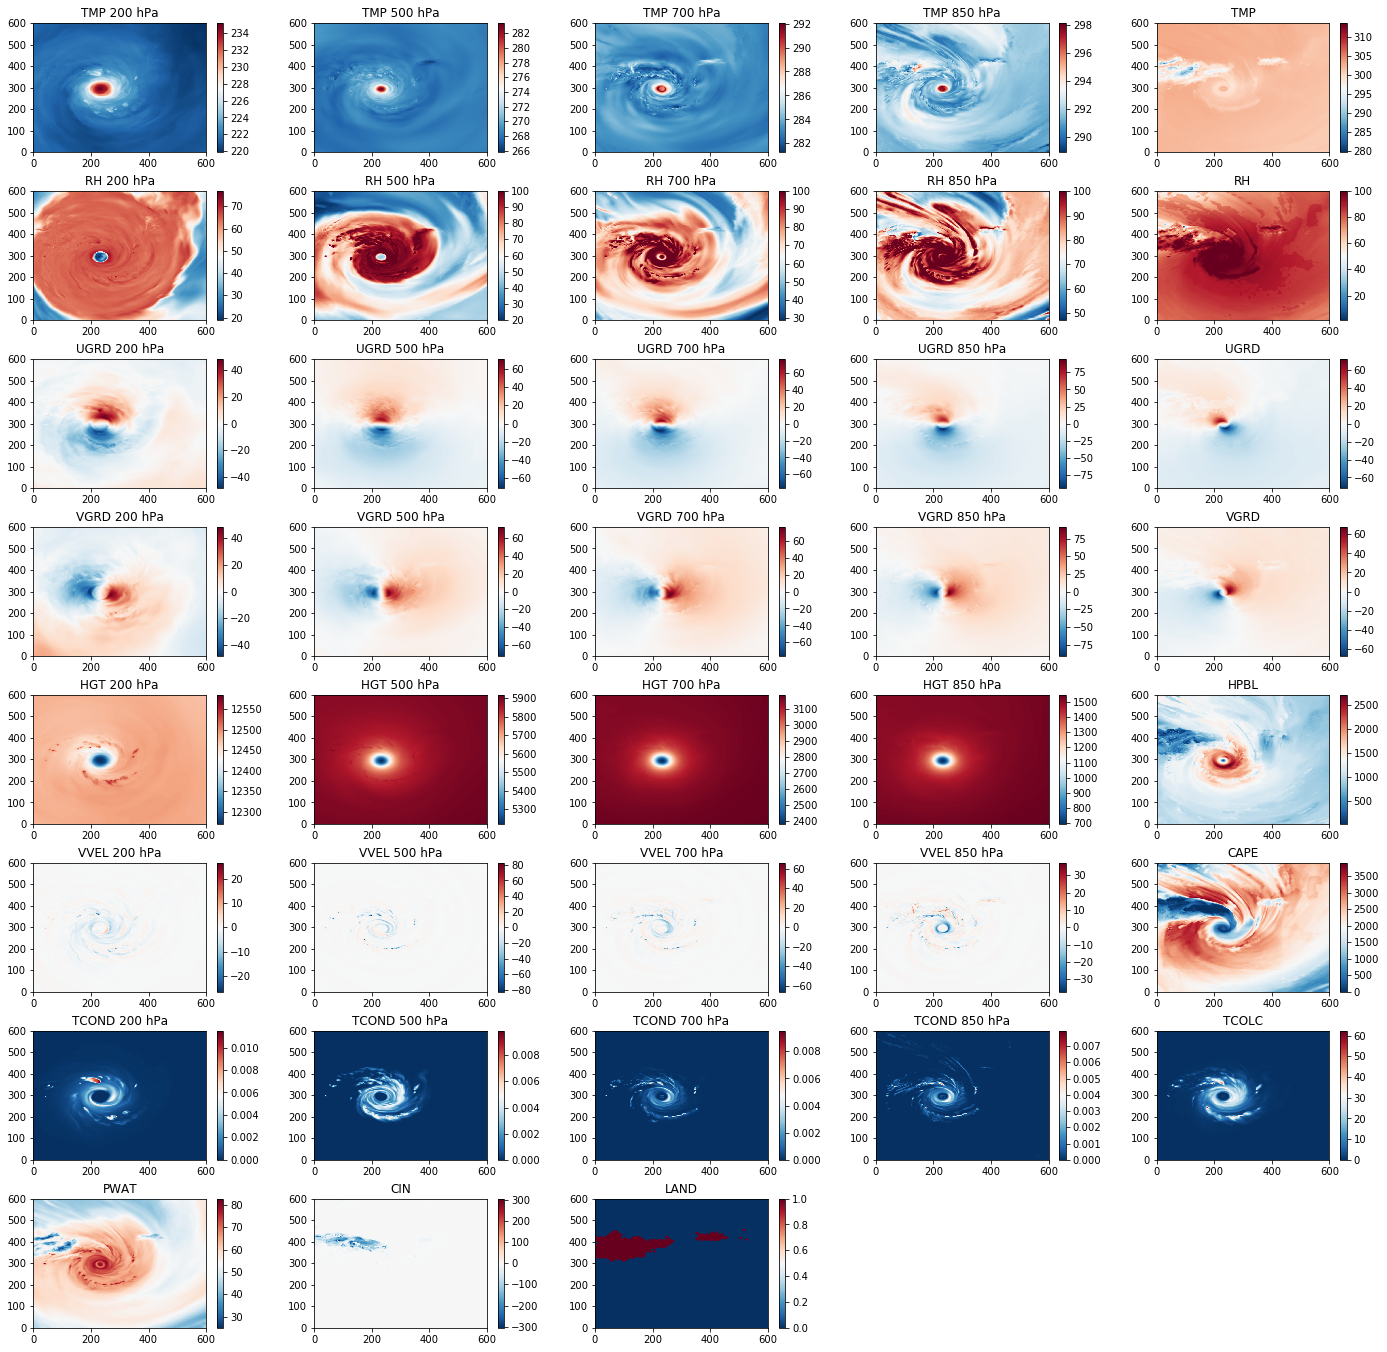

In [52]:
fig, axes = plt.subplots(8, 5, figsize=(24, 24))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
for a, ax in enumerate(axes.ravel()):
    if a < len(hwrf_var_levels):
        print(hwrf_var_levels[a])
        var_data = hs.get_variable(*hwrf_var_levels[a]).values
        if np.count_nonzero(var_data < 0) > 0:
            vmax = np.abs(var_data).max()
            vmin = -vmax
        else:
            vmax = var_data.max()
            vmin = var_data.min()
        pc = ax.pcolormesh(np.arange(601), np.arange(601), var_data, vmin=vmin, vmax=vmax, cmap="RdBu_r")
        plt.colorbar(pc, ax=ax)
        title = hwrf_var_levels[a][0].split("_")[0]
        if hwrf_var_levels[a][1] is not None:
            title += f" {hwrf_var_levels[a][1] / 100:0.0f} hPa"
        ax.set_title(title, fontsize=12)
    else:
        ax.axis('off')
plt.savefig("hurricane_tiles.png", dpi=300, bbox_inches="tight")

In [47]:
hwrf_vars = ['UGRD_P0_L103_GLL0', 'VGRD_P0_L103_GLL0']
hwrf_levels = [None, None, None]
bt_inputs = ["LAT_smooth", "LON_smooth", "MIN_SLP_smooth"]
bt_labels = ["vmax_bt"]
batch_size = 32
x_start = 300 - 32
x_end = 300 + 32
hw_seq = HWRFSequence(hwrf_files_sub, bt, hwrf_vars, hwrf_levels, bt_inputs, bt_labels, batch_size, x_start=x_start, x_end=x_end)

In [ ]:
hwrf

In [6]:
%timeit output = hw_seq[1]

6.54 s ± 245 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [60]:
hwrf_files_fh = hwrf_files = sorted(glob(hwrf_path + "*f003.nc"))

var_counts = np.zeros(len(hwrf_files_fh), dtype=int)

for h, hwrf_file in enumerate(hwrf_files_fh):
    ds = Dataset(hwrf_file)
    var_counts[h] = len(list(ds.variables.keys()))
    ds.close()
    if h % 500 == 0:
        print(h, hwrf_file, var_counts[h])
    if var_counts[h] != 20:
        print(h, hwrf_file, var_counts[h])

0 /glade/p/ral/nsap/rozoff/hfip/reforecast/agatha02e.2016070218.f003.nc 20
500 /glade/p/ral/nsap/rozoff/hfip/reforecast/fifteen15e.2017091118.f003.nc 20


KeyboardInterrupt: 

In [56]:
ds = xr.open_dataset("/glade/p/ral/nsap/rozoff/hfip/reforecast/thirteen13l.2017090600.f002.nc")
print(list(ds.variables.keys()))
print(len(list(ds.variables.keys())))

['TMP_P0_L100_GLL0', 'UGRD_P0_L100_GLL0', 'UGRD_P0_L103_GLL0', 'VGRD_P0_L100_GLL0', 'VGRD_P0_L103_GLL0', 'HGT_P0_L100_GLL0', 'lat_0', 'lon_0', 'lv_ISBL0']
9


In [14]:
109624 / 64

1712.875

In [8]:
scn = StandardConvNet(output_activation="linear", use_dropout=True, dropout_alpha=0.2)
scn.build_network((64, 64, 2), (len(bt_inputs),), 1)
scn.compile_model()
scn.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scn_input (InputLayer)          (None, 64, 64, 2)    0                                            
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 64, 64, 2)    8           scn_input[0][0]                  
__________________________________________________________________________________________________
conv_00 (Conv2D)                (None, 64, 64, 16)   816         batch_normalization_2[0][0]      
__________________________________________________________________________________________________
hidden_activation_00 (Activatio (None, 64, 64, 16)   0           conv_00[0][0]                    
__________________________________________________________________________________________________
pooling_00

In [9]:
out_history = scn.model.fit_generator(hw_seq, epochs=5, verbose=1, workers=16, 
                                      use_multiprocessing=True, shuffle=True)

Epoch 1/5
1981/1981 [==============================] - 1135s 573ms/step - loss: 806.5114
Epoch 2/5
1981/1981 [==============================] - 1085s 547ms/step - loss: 520.1348
Epoch 3/5
1981/1981 [==============================] - 1060s 535ms/step - loss: 499.1863
Epoch 4/5
1981/1981 [==============================] - 1083s 547ms/step - loss: 483.7775
Epoch 5/5
1981/1981 [==============================] - 1082s 546ms/step - loss: 475.6123


In [43]:
loss = (scn.model.output - 120) ** 2
grad_fields = K.gradients(loss, scn.model.input)
print(grad_fields)
#grad /= K.maximum(K.std(grad), K.epsilon())
grad_func = K.function(scn.model.input + [K.learning_phase()], grad_fields + [loss])

[<tf.Tensor 'gradients_8/AddN_3:0' shape=(?, 64, 64, 2) dtype=float32>, <tf.Tensor 'gradients_8/AddN_2:0' shape=(?, 3) dtype=float32>]


In [45]:
input_field = np.zeros((1, 64, 64, 2), dtype=np.float32)
input_scalar = np.zeros((1, 3), dtype=np.float32)
for i in range(1000):
    grad = grad_func([input_field, input_scalar, 0])
    input_field -= 0.1 * grad[0]
    input_scalar -= 0.1 * grad[1]


In [84]:
input_field.max()

43.79886

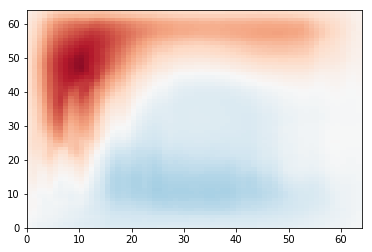

In [86]:
plt.pcolormesh(gaussian_filter(input_field[0, :, :, 0], 1), cmap="RdBu_r", vmin=-40, vmax=40)

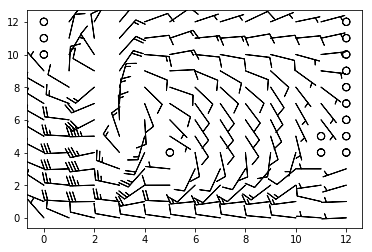

In [75]:
plt.barbs(gaussian_filter(input_field[0, ::-5, ::5, 0], input_field[0, ::-5, ::5, 1])

In [65]:
out = hw_seq[25]

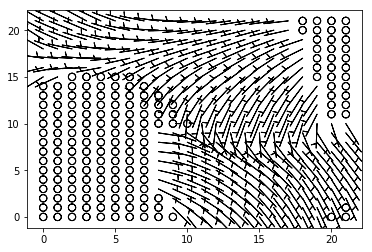

In [66]:
plt.barbs(out[0][0][0, ::3, ::3, 0], out[0][0][0, ::3, ::3, 1])

In [64]:
len(out[0])

2